In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_owd = pd.read_csv("./dataset/data_stamet_ngurah_rai_pre.csv", parse_dates=True)
df_owd.rename(columns = {'Tanggal':'dt_iso', 'Tn':'temp_min_min', 
    'Tx':'temp_max_max', 'Tavg':'temp_mean', 'RH_avg':'humidity_mean', 
    'ff_avg':'wind_speed_mean', 'RR':'rain_1d'}, inplace = True)
df_owd['dt_iso'] = pd.to_datetime(df_owd['dt_iso'], format='%d-%m-%Y')
df_owd.head()

,dt_iso,temp_min_min,temp_max_max,temp_mean,humidity_mean,wind_speed_mean,rain_1d
0,1990-01-01,25.0,32.8,29.1,75.0,2.0,0.0
1,1990-01-02,26.0,31.0,26.4,86.0,1.0,0.0
2,1990-01-03,25.0,31.6,27.9,76.0,2.0,17.2
3,1990-01-04,25.0,30.8,28.0,81.0,2.0,34.8
4,1990-01-05,25.0,29.8,27.2,86.0,2.0,6.1


### Cleansing

Check nilai 8888 dan 9999. 8888 berarti tidak terbaca karena nilainya sangat kecil sedangkan 9999 biasanya dikarenakan alat rusak

In [3]:
print((df_owd == 8888).any())
print((df_owd == 9999).any())

dt_iso             False
temp_min_min       False
temp_max_max       False
temp_mean          False
humidity_mean      False
wind_speed_mean    False
rain_1d             True
dtype: bool
dt_iso             False
temp_min_min       False
temp_max_max       False
temp_mean          False
humidity_mean      False
wind_speed_mean    False
rain_1d            False
dtype: bool


Replace 8888 with 0

In [4]:
df_owd = df_owd.replace(8888, 0)

Check NaN value

In [5]:
print((df_owd.isna()).any())

dt_iso             False
temp_min_min        True
temp_max_max        True
temp_mean           True
humidity_mean       True
wind_speed_mean     True
rain_1d             True
dtype: bool


Replace NaN with mean di kolom yang bersangkutan

In [6]:
df_owd.fillna(df_owd.mean(), inplace = True)

c:\Users\azrina\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


## EDA

Pola curah hujan dalam satu tahun

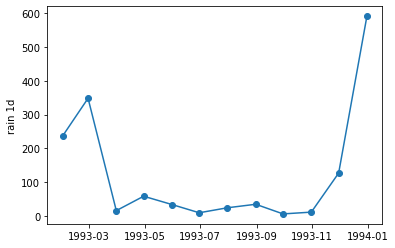

In [7]:
df_1993 = df_owd[(df_owd['dt_iso'] >= '1993-01-01') & (df_owd['dt_iso'] <= '1993-12-31')]
plt.plot(df_1993.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum(), marker='o')
plt.ylabel("rain 1d")
plt.show()

Dari plot terlihat data mengikuti pola yang valid

- Denpasar mengikuti pola Monsoon, 
- Puncak musim hujan berada di **Dec-Jan-Feb (DJF)**
- Puncak musim kemarau berada di **Jun-Jul-Aug (JJA)**

<img src='images/pola.jpeg'></img>

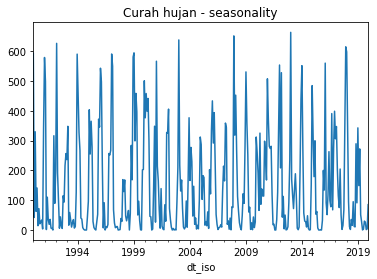

In [8]:
df_owd.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum().plot()
plt.title('Curah hujan - seasonality')
plt.show()

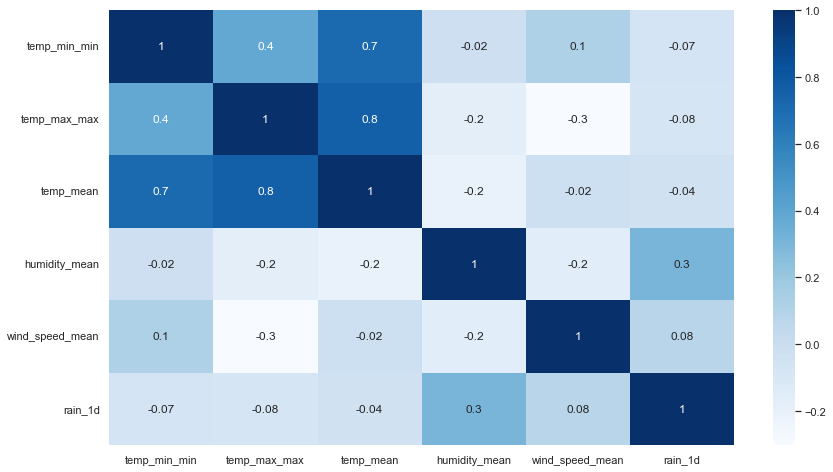

In [9]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_owd.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

Hasil korelasi parameter tidak ada korelasi yang kuat antara curah hujan dan parameter lainnya

Namun pada riset ini diangkut semua paramater karena parameter tersebut yang biasa dipakai dalam prediksi curah hujan

### Dataset Statistik

In [10]:
df_owd.describe()

,temp_min_min,temp_max_max,temp_mean,humidity_mean,wind_speed_mean,rain_1d
count,10957.000000,10957.000000,10957.000000,10957.000000,10957.000000,10957.000000
mean,24.632622,30.634704,27.203018,80.502927,3.086081,4.938395
std,1.380008,1.345982,1.184370,4.832626,1.372721,14.186706
min,18.000000,25.200000,21.700000,55.000000,0.000000,0.000000
25%,24.000000,29.700000,26.500000,78.000000,2.000000,0.000000
50%,25.000000,30.600000,27.300000,80.000000,3.000000,0.000000
75%,25.000000,31.600000,28.000000,84.000000,4.000000,2.000000
max,29.000000,35.200000,30.700000,99.000000,17.000000,231.400000


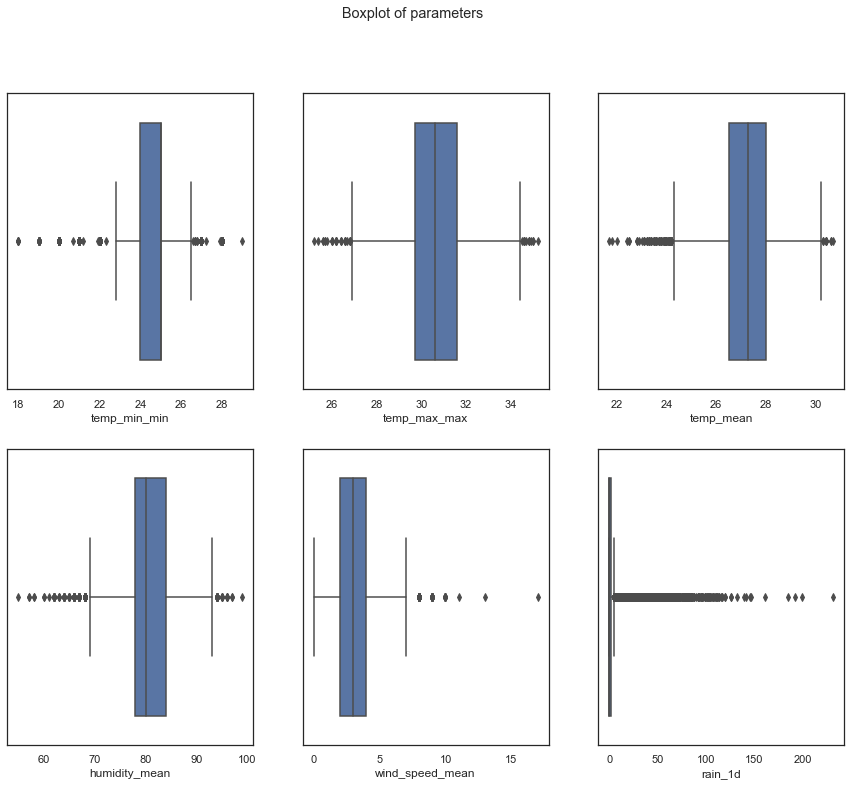

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Boxplot of parameters')
i, j = 0, 0
for c in df_owd:
    if c != 'dt_iso':
        sns.boxplot(ax=axes[i, j], x=df_owd[c])

        j = j + 1
        if j >= 3:
            j = 0
            i = i + 1

Dari boxplot dapat dilihat bahwa yang mendekati distribusi normal hanyalah **temp_max**

Sehingga untuk keseragaman maka normalisasi tidak menggunakan z-score melainkan min-max,  

## Preprocess

In [12]:
df_owd_train = df_owd[(df_owd['dt_iso'] <= '2018-12-31')]
df_owd_test = df_owd[(df_owd['dt_iso'] >= '2019-01-01') & (df_owd['dt_iso'] <= '2019-12-31')] # ignore 2020

In [13]:
df_owd = df_owd.set_index('dt_iso')
df_owd_train = df_owd_train.set_index('dt_iso')
df_owd_test = df_owd_test.set_index('dt_iso')

In [14]:
sc = MinMaxScaler(feature_range = (0, 1))
norm_df_owd = sc.fit_transform(df_owd_train)

# norm_df_owd = (df_owd - df_owd.min(axis=0)) / (df_owd.max(axis=0) - df_owd.min(axis=0))
norm_df_owd

array([[0.63636364, 0.76      , 0.83146067, 0.45454545, 0.11764706,
        0.        ],
       [0.72727273, 0.58      , 0.52808989, 0.70454545, 0.05882353,
        0.        ],
       [0.63636364, 0.64      , 0.69662921, 0.47727273, 0.11764706,
        0.07433016],
       ...,
       [0.72727273, 0.68      , 0.83146067, 0.45454545, 0.47058824,
        0.01555748],
       [0.72727273, 0.53      , 0.70786517, 0.54545455, 0.35294118,
        0.01728608],
       [0.72727273, 0.6       , 0.75280899, 0.47727273, 0.11764706,
        0.        ]])

In [77]:
# norm_df_owd = norm_df_owd.reset_index()

### Windowing dataset

In [78]:
# #Empty lists to be populated using formatted training data
# trainX = []
# trainY = []

# n_future = 30   # Number of days we want to look into the future based on the past days.
# n_past = 60  # Number of past days we want to use to predict the future.
# n_feature = 9

# #Reformat input data into a shape: (n_samples x timesteps x n_features)
# #In my example, my df_for_training_scaled has a shape (12823, 5)
# #12823 refers to the number of data points and 5 refers to the columns (multi-variables).
# for i in range(n_past, len(norm_df_owd) - n_future + 1):
#     trainX.append(norm_df_owd[i - n_past:i, 0:norm_df_owd.shape[1]]) # input multi var
#     trainY.append(norm_df_owd[i + n_future - 1:i + n_future, norm_df_owd.shape[1]- 1]) # output 1 var

# trainX, trainY = np.array(trainX), np.array(trainY)

# print('trainX shape == {}.'.format(trainX.shape))
# print('trainY shape == {}.'.format(trainY.shape))

In [15]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [16]:
past_history = 730
future_target = 365
n_feature = 6
STEP = 1 # 6
TRAIN_SPLIT = 9496 # 2016
x_train_multi, y_train_multi = multivariate_data(norm_df_owd, norm_df_owd[:, 5], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(norm_df_owd, norm_df_owd[:, 5],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

## Model

In [17]:
model = keras.models.Sequential([
  keras.layers.Bidirectional(keras.layers.GRU(units=32, return_sequences = True, input_shape=(past_history, n_feature))),
  keras.layers.Dropout(0.2),
  keras.layers.Bidirectional(keras.layers.GRU(units=32)),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(units = future_target)
])

In [18]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [19]:
epoch = 10
batch_size = 128
model.fit(x_train_multi, y_train_multi, validation_data=(x_val_multi, y_val_multi), epochs = epoch, batch_size = batch_size)

Epoch 1/10
69/69 [==============================] - 123s 2s/step - loss: 0.0046 - val_loss: 0.0029
Epoch 2/10
69/69 [==============================] - 115s 2s/step - loss: 0.0038 - val_loss: 0.0028
Epoch 3/10
69/69 [==============================] - 131s 2s/step - loss: 0.0037 - val_loss: 0.0026
Epoch 4/10
69/69 [==============================] - 144s 2s/step - loss: 0.0037 - val_loss: 0.0026
Epoch 5/10
69/69 [==============================] - 160s 2s/step - loss: 0.0036 - val_loss: 0.0026
Epoch 6/10
69/69 [==============================] - 130s 2s/step - loss: 0.0036 - val_loss: 0.0026
Epoch 7/10
69/69 [==============================] - 129s 2s/step - loss: 0.0036 - val_loss: 0.0026
Epoch 8/10
69/69 [==============================] - 130s 2s/step - loss: 0.0036 - val_loss: 0.0026
Epoch 9/10
69/69 [==============================] - 125s 2s/step - loss: 0.0035 - val_loss: 0.0025
Epoch 10/10
69/69 [==============================] - 117s 2s/step - loss: 0.0035 - val_loss: 0.0026


In [20]:
model.save('./model/model2.h5')

### Testing

In [21]:
X_predict = norm_df_owd[-past_history:].reshape((-1, past_history, n_feature))

In [22]:
hasil = model.predict(X_predict)

1/1 [==============================] - 1s 1s/step


In [23]:
max = sc.data_max_[-1]
min = sc.data_min_[-1]
y_descaled = hasil * (max - min) + min
y_descaled

array([[7.0139403, 7.459704 , 7.12051  , 7.4564447, 6.5634823, 6.8670983,
        7.995443 , 7.928739 , 7.1106577, 7.735153 , 7.9269867, 7.963129 ,
        6.623399 , 8.211858 , 7.904143 , 7.365818 , 8.269008 , 6.960419 ,
        7.851601 , 8.28651  , 7.8683767, 7.51351  , 7.1131806, 7.5989046,
        7.1649666, 8.027683 , 7.826396 , 7.2977624, 8.046264 , 9.053699 ,
        7.934862 , 7.9175653, 7.8933287, 7.6119566, 8.030977 , 8.06297  ,
        8.701451 , 7.7002783, 7.605496 , 8.879642 , 8.815792 , 8.123685 ,
        8.709371 , 8.4298   , 8.461275 , 8.904053 , 8.568888 , 8.501236 ,
        8.641216 , 8.08299  , 8.393825 , 8.224176 , 8.457149 , 7.046141 ,
        7.541486 , 8.017775 , 7.997498 , 8.256143 , 7.4634166, 8.314102 ,
        8.135672 , 7.9056597, 7.5404315, 7.305974 , 7.796368 , 7.652823 ,
        7.409367 , 7.8056684, 7.934191 , 6.802555 , 8.021126 , 8.200685 ,
        8.133205 , 6.997682 , 7.66324  , 7.6345067, 7.613354 , 7.6353703,
        6.9498143, 6.2388167, 6.573462

In [24]:
total_1d_predicted = pd.Series(y_descaled.flatten(), name='total_1d_predicted')

df_owd_test = df_owd_test.reset_index()
aggregated_2019_df = pd.concat([df_owd_test, total_1d_predicted], axis=1)

In [25]:
rain_1M_2019 = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum()
rain_1M_2019_pred = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).total_1d_predicted.sum()

# (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
rain_1M_2019 = (rain_1M_2019 - min) / (max - min)
rain_1M_2019_pred = (rain_1M_2019_pred - min) / (max - min)
mse = ((rain_1M_2019_pred - rain_1M_2019) ** 2).sum() / 12
print(mse)

0.19756536672321998


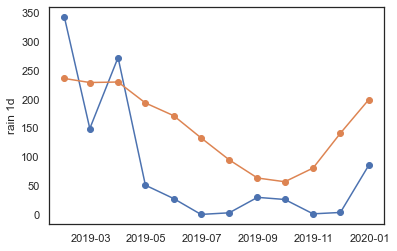

In [26]:
plt.plot(aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum(), marker='o')
plt.plot(aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).total_1d_predicted.sum(), marker='o')
plt.ylabel("rain 1d")
plt.show()

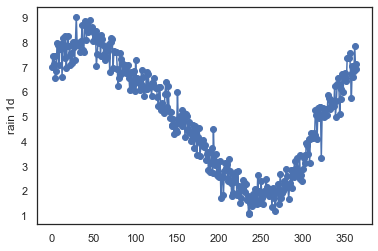

In [27]:
plt.plot(y_descaled.flatten(), marker='o')
plt.ylabel("rain 1d")
plt.show()